In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy import integrate
import AnaUtils as au
import Triggered as tr
import glob
import os

In [2]:
pmt = "SA5446"
wdir = '/data/share/ReplacementPMTs'
fWaves = [os.path.splitext(iF)[0] for iF in glob.glob('{}/{}/Gain/*.bin'.format(wdir,pmt))]
fWaves.sort() 
Gains = np.array([float(iF.split('/')[-1].split('V')[0]) for iF in fWaves])
nGains = len(Gains)
print(Gains,fWaves,nGains)

[1575. 1600. 1700. 1725.] ['/data/share/ReplacementPMTs/SA5446/Gain/1575V_200825_100_samples_30000_events', '/data/share/ReplacementPMTs/SA5446/Gain/1600V_200825_100_samples_30000_events', '/data/share/ReplacementPMTs/SA5446/Gain/1700V_200825_100_samples_30000_events', '/data/share/ReplacementPMTs/SA5446/Gain/1725V_200825_100_samples_30000_events'] 4


[-1.01841298e-01  1.80183938e+02  2.83176111e-01 -1.61583316e-01
  2.61055989e+01 -6.19121488e-01]
[-3.71250065e-02  8.50647610e+04  4.61043142e-02  1.93029990e-03
  4.37021096e+03  3.75829947e-01]
[-5.04899322e-02  1.68632001e+02  2.61569083e-01 -1.71815906e-01
  3.82591885e+01 -5.72268867e-01]
[-5.29988506e-02  1.77406455e+02  2.73601475e-01 -2.30721083e-01
  2.66979372e+01  6.57423454e-01]


(array([1575., 1600., 1700., 1725.]),
 array([-0.1008509 ,  0.00120478, -0.10723749, -0.14400267]),
 array([0.02033673, 0.00209055, 0.01397499, 0.01572598]))

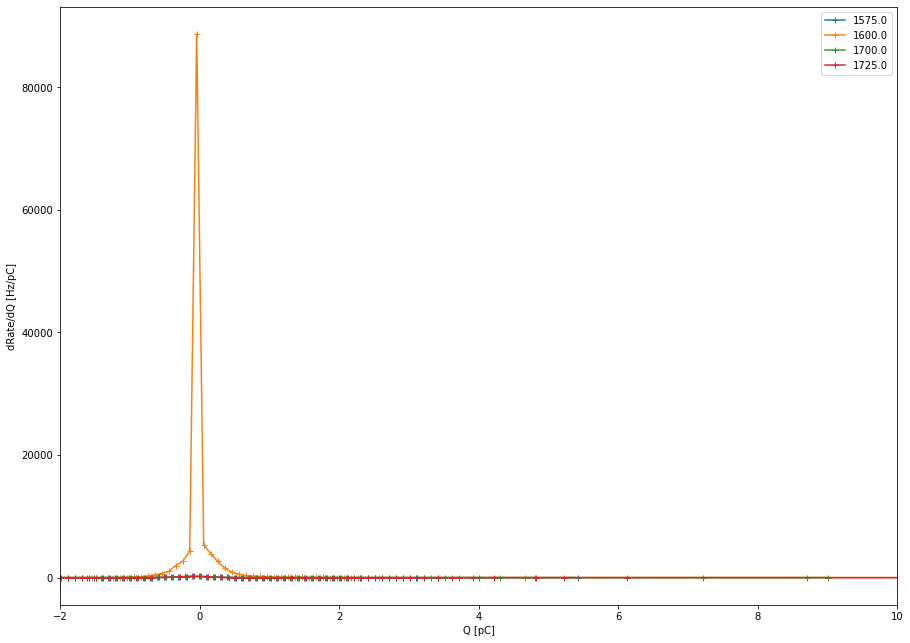

In [4]:
QHists = [tr.extRun(iG,30,5,6,qbins=100,qW=0.1,plot=False) for iG in fWaves]
QSPE = np.array([0.]*nGains)
QErr = np.array([0.]*nGains)
for iq in range(nGains):
    #plt.plot(QHists[iq][1],QHists[iq][2],marker='x',label=Gains[iq])
    args = QHists[iq][3]
    lst = 'solid'
    try:
        GFit,GErr = tr.fitQ(QHists[iq],[0,10,0.5,2,1,1])#,3.2,0.1,1])
        QSPE[iq] = GFit[3]
        print(GFit)
        QErr[iq] = np.sqrt(np.diag(GErr))[3]
    except RuntimeError as e:
        print("Failed to fit {}V Run: {}".format(Gains[iq],e))
        lst = 'dashed'
        QSPE[iq] = np.nan
        QErr[iq] = np.nan
        #plt.plot(QHists[iq][1],QHists[iq][0],marker='x',label=Gains[iq])
    plt.plot(QHists[iq][1][args],QHists[iq][0][args],marker='+',label=Gains[iq],linestyle=lst)
#plt.yscale('log')
plt.xlim(-2,10)
plt.legend()
plt.xlabel('Q [pC]')
plt.ylabel('dRate/dQ [Hz/pC]')
plt.savefig("{}/figs/{}_GainSPEs.png".format(wdir,pmt))

Gains,QSPE/1.6022,QErr

In [4]:
def fit_gain_curve(v, v0, gamma):
    q = ( v / v0 ) ** gamma
    return q
def fit_gain_line(v,v0,gamma):
    q = gamma*v + v0
    return q
qe = 1.6022e-7
from scipy.optimize import curve_fit
fitQ,fitErr = curve_fit(fit_gain_line,Gains,np.log(QSPE/qe),p0=[1,1e3],sigma=QErr/QSPE,absolute_sigma=True)
fitErr = np.sqrt(np.diag(fitErr))
print((fitQ,fitErr,(np.log(1e7)-fitQ[0])/fitQ[1]))

"""
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(Gains,np.log(QSPE/qe))
print(slope, intercept, std_err,(np.log(1e7)-intercept)/slope)
"""


/home/lzer/miniconda3/envs/DDC10Ana/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


ValueError: array must not contain infs or NaNs

In [ ]:
points = np.exp(fitQ[1] * np.array(Gains) + fitQ[0])
pointerr = np.sqrt(np.square(fitErr[1]/fitQ[1])+np.square(fitErr[0]/fitQ[0]))*points
plt.errorbar(Gains,points,yerr=pointerr,label='Fit')
plt.errorbar(Gains,QSPE/qe,label='data',yerr = QErr/qe)
plt.plot()
#plt.yscale('log')
#plt.xlim(-2,10)
plt.xlabel('Bias [V]')
plt.ylabel('Gain')
plt.legend()
plt.savefig("{}/figs/{}_GainCurve.png".format(wdir,pmt))


## 